### Load

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
df = pd.read_csv('loading_data_max.csv')
df.shape

(628, 34)

In [3]:
X = df.drop(['filling_space_percent','density_percent'], axis=1)
y = df['filling_space_percent']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### XGBoost

In [6]:
import xgboost as xgb
from xgboost import XGBRegressor

In [7]:
#Подбираем параметры
estimator = XGBRegressor()

parameters = {
    "eta":[0.2,0.3,0.4],
    "gamma": [0,1,2],
    "lambda": [0.5,2],
    "alpha": [0.5,2],
    #"n_estimators":[200,100],
    #'n_jobs':[10,20]
    }



skf=KFold(n_splits=10)
clf = GridSearchCV(estimator=estimator, scoring='r2',param_grid=parameters,n_jobs = 10, cv=skf,verbose=True)

clf.fit(X, y)
param=clf.best_params_
print(clf.best_params_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
{'alpha': 2, 'eta': 0.2, 'gamma': 0, 'lambda': 0.5}


In [8]:
%%time
model = xgb.XGBRegressor(**param)
model.fit(X_train, y_train)

Wall time: 93.7 ms


XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', lambda=0.5, learning_rate=0.200000003,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0, ...)

In [9]:
from sklearn import metrics

R^2_XGBoost: 0.9754


<AxesSubplot:xlabel='filling_space_percent'>

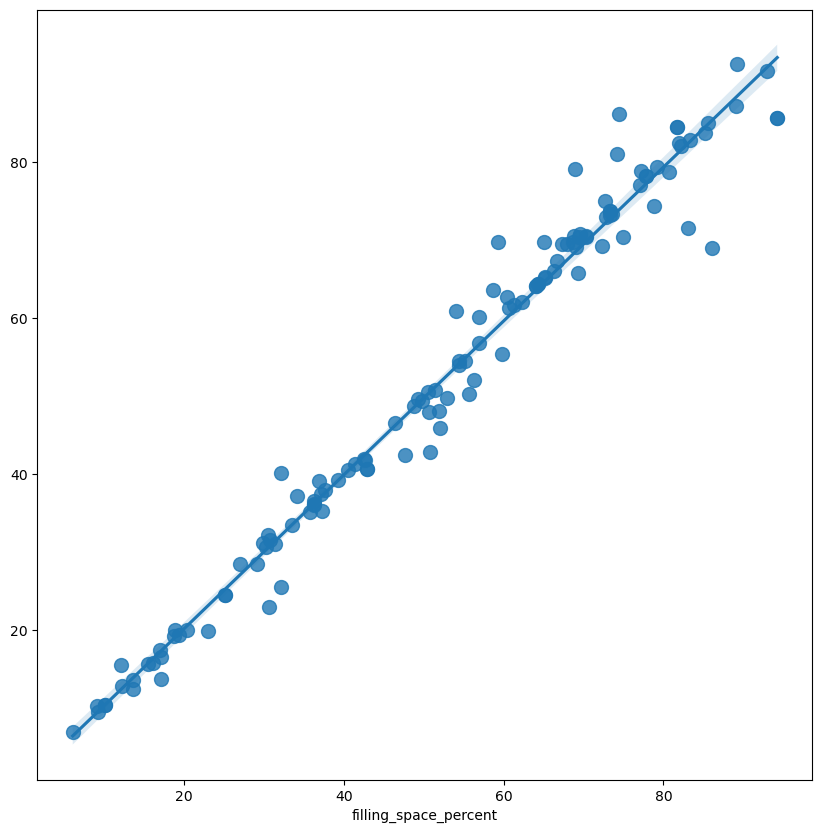

In [10]:
expected_y  = y_test
predicted_y = model.predict(X_test)


print(f'R^2_XGBoost: {metrics.r2_score(expected_y, predicted_y):.4f}')
#print(metrics.mean_squared_log_error(expected_y, predicted_y))

plt.figure(figsize=(10,10))
sns.regplot(x=expected_y, y=predicted_y, fit_reg=True, scatter_kws={"s": 100})

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

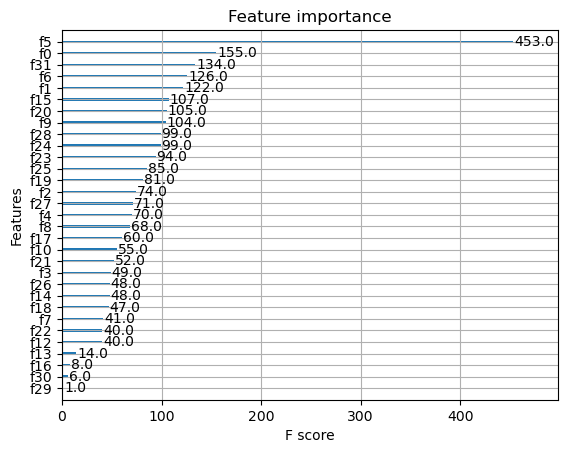

In [11]:
xgb.plot_importance(model)

In [12]:
#Обучим модель на всех данных для выгрузки
model.fit(X, y)

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', lambda=0.5, learning_rate=0.200000003,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0, ...)

In [13]:
#Выгрузим параметры
params = model.get_params()
df = pd.DataFrame(params.items(), columns=['Parameter', 'Value'])
df.to_csv('xgboost_params.csv', index=False)